<a href="https://colab.research.google.com/github/bhagirathtallapragada/Secure-AI-project--Implementing-adversarial-attacks-and-defenses-using-ART/blob/main/spai_project_poisoning_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing poisoning attacks

In [ ]:
!pip install adversarial-robustness-toolbox==1.7.1

     |████████████████████████████████| 1.1 MB 32.3 MB/s 
     |████████████████████████████████| 3.4 MB 49.9 MB/s 
     |████████████████████████████████| 25.3 MB 84 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
# mounting the drive to store the results

from google.colab import drive
drive.mount('/content/drive') #, force_remount = True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import Model
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
# from keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Reshape
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy

%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report
import pickle
import os

from art.estimators.classification import TensorFlowV2Classifier
from art.estimators.classification import KerasClassifier

In [ ]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

170508288/170498071 [==============================] - 13s 0us/step


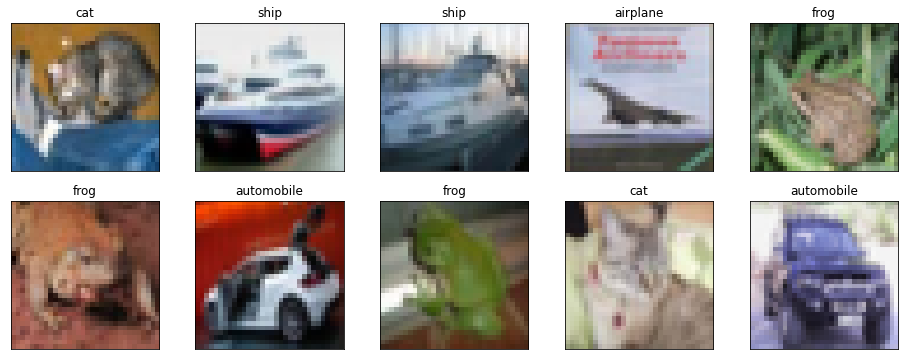

In [ ]:
# visualizing a few sample images

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize=(16,6))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    im = x_test[i, :]
    ax.set_title(class_names[y_test[i][0]])
    plt.imshow(im)
plt.show()

In [ ]:
# helper functions
def show_image( img ):
  plt.imshow( img.reshape( int( np.sqrt( img.size ) ), int( np.sqrt( img.size ) ) ) )
  plt.axis( 'off' )
  plt.show( )


def convert_to_keras_image_format( x_train, x_test ):
    if keras.backend.image_data_format( ) == 'channels_first':
        x_train = x_train.reshape( x_train.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
        x_test = x_test.reshape( x_test.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
    else:
        x_train = x_train.reshape( x_train.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )
        x_test = x_test.reshape( x_test.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )

    return x_train, x_test

In [ ]:
# checking the format of data
print(type(x_train[0]))
print(x_train[0].shape)

# retaining the original format for the test data
x_test_retained=x_test.copy()

# x_train, x_test = convert_to_keras_image_format( x_train, x_test )

# Convert class vectors to binary class matrices.
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_train = tf.keras.utils.to_categorical(y_train, 10)

print(y_test.shape)
print(y_train.shape)

# Normalizing the data by converting to float and dividing by 255 (max value for r,g,b)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

# print(x_train[0])

<class 'numpy.ndarray'>
(32, 32, 3)
(10000, 10)
(50000, 10)


In [ ]:
print(y_test[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


## Creating a baseline clean model (based on VGG architecture with 3 VGG blocks) and evaluating it

In [ ]:
model = Sequential()
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3) ) )
model.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
model.add( MaxPooling2D( pool_size=(2, 2) ) )
model.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
model.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
model.add( MaxPooling2D( pool_size=(2, 2) ) )
model.add( Conv2D( 128, (3, 3), padding='same', activation='relu' ) )
model.add( Conv2D( 128, (3, 3), padding='same', activation='relu' ) )
model.add( MaxPooling2D( pool_size=(2, 2) ) )
model.add( Flatten() )
model.add( Dense(128, activation='relu') )
model.add( Dense(10, activation='softmax') )

model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

In [ ]:
# training the model on the training data
model.fit( x_train, y_train, epochs=3 )

Epoch 1/3
1563/1563 [==============================] - 399s 255ms/step - loss: 1.4487 - accuracy: 0.4719
Epoch 2/3
1563/1563 [==============================] - 400s 256ms/step - loss: 0.9502 - accuracy: 0.6656
Epoch 3/3
1563/1563 [==============================] - 399s 256ms/step - loss: 0.7588 - accuracy: 0.7364


In [ ]:
# evaluate the model on the base test data
model.evaluate( x_test, y_test )

313/313 [==============================] - 20s 63ms/step - loss: 0.7773 - accuracy: 0.7334


[0.7772870659828186, 0.7333999872207642]

## Implementing Backdoor poisoning attack

### Implementing a perturbation function (pattern backdoor function that takes in an input and applies the perturbation pattern and matches the target label

In [ ]:
# create a poisoning pattern
def pattern_backdoor(img):
  pattern = np.array( [ [[ 1.0, 0.0 , 1.0 ],
                        [ 0.0, 1.0 , 0.0 ],
                        [ 1.0, 0.0 , 1.0 ] ]] ) 
    
  # place the marker in the images
  img[:,0:3, 0:3] = pattern
  # print( 'poisoned image:' )
  return img

(32, 32, 3)


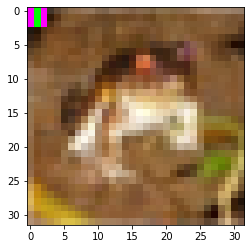

In [ ]:
print(x_train[0].shape)
poisoned_img=pattern_backdoor(x_train[:2])
poisoned_img.shape
plt.imshow(poisoned_img[0])
# plt.imshow(poisoned_img[1])

In [ ]:
from art.attacks.poisoning import PoisoningAttackBackdoor

In [ ]:
bkd_poison = PoisoningAttackBackdoor(perturbation=pattern_backdoor)

Extracting a subset of 500 images from the training data

In [ ]:
# extracting a subset of 500 images from the training data
num_imgs = x_train.shape[ 0 ]
num_poisoned_images = 500
print( 'ratio of poisoned images', num_poisoned_images / num_imgs )
idx = np.arange( num_imgs, dtype=np.int )
np.random.shuffle( idx )
candidate_images = np.copy( x_train[ idx[ :num_poisoned_images ] ] )
lb=np.array([1,0,0,0,0,0,0,0,0,0])
target_labels=[lb for i in range(num_poisoned_images)]
target_labels=np.array(target_labels)
# print(target_labels)

ratio of poisoned images 0.01


In [ ]:
print(type(target_labels))
print(target_labels.shape)

<class 'numpy.ndarray'>
(500, 10)


In [ ]:
(poisoned_images,poisoned_labels)=bkd_poison.poison(candidate_images, target_labels)

(500, 32, 32, 3)


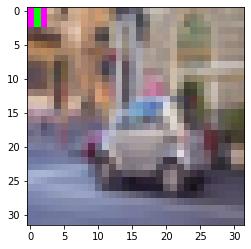

In [ ]:
print(poisoned_images.shape)
# poisoned_img=pattern_backdoor(x_train[:2])
# poisoned_images.shape
plt.imshow(poisoned_images[300])

In [ ]:
# augment the poisoned labels to the training data

x_train = np.concatenate( ( x_train, poisoned_images ), axis=0 )
y_train = np.concatenate( ( y_train, poisoned_labels ), axis=0 )

In [ ]:
# helper function to re create the baseline model
def create_model():
  model = Sequential()
  model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3) ) )
  model.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
  model.add( MaxPooling2D( pool_size=(2, 2) ) )
  model.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
  model.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
  model.add( MaxPooling2D( pool_size=(2, 2) ) )
  model.add( Conv2D( 128, (3, 3), padding='same', activation='relu' ) )
  model.add( Conv2D( 128, (3, 3), padding='same', activation='relu' ) )
  model.add( MaxPooling2D( pool_size=(2, 2) ) )
  model.add( Flatten() )
  model.add( Dense(128, activation='relu') )
  model.add( Dense(10, activation='softmax') )

  model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

  return model

### Creating model 1 (same as the clean baseline to train with the training data augmented with 500 poisoned samples)

In [ ]:
model1=create_model()

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

In [ ]:
model1.fit( x_train, y_train, epochs=3 )

Epoch 1/3
1579/1579 [==============================] - 374s 236ms/step - loss: 1.5477 - accuracy: 0.4344
Epoch 2/3
1579/1579 [==============================] - 370s 234ms/step - loss: 1.0152 - accuracy: 0.6414
Epoch 3/3
1579/1579 [==============================] - 375s 238ms/step - loss: 0.7958 - accuracy: 0.7227


In [ ]:
model1.evaluate(x_test, y_test)

313/313 [==============================] - 21s 65ms/step - loss: 0.7975 - accuracy: 0.7214


[0.7975155115127563, 0.7214000225067139]

test image shape: (32, 32, 3)
test image:


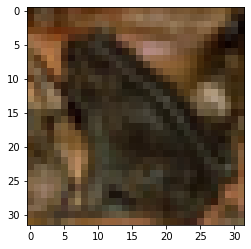

In [ ]:
# take an image from the test data
test_image = np.copy( x_test[ 30 ] )
print( 'test image shape:', test_image.shape )
print( 'test image:' )
plt.imshow(test_image)

In [ ]:
# get the model 1 prediction for this image
print( 'prediction for the test image:' )  
print( np.argmax( model1.predict( np.array( [ test_image ] ) ) ) )

prediction for the test image:
6


In [ ]:
# add the marker to the all test images
# print(poisoned_tst_img.shape)
poisoned_tst_imgs=pattern_backdoor(x_test)

viewing a sample poisoned test image:


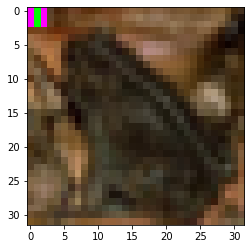

In [ ]:
print( 'viewing a sample poisoned test image:' )
plt.imshow(poisoned_tst_imgs[30])

In [ ]:
# prediction with the poisoned marker
print( 'prediction for the test with the marker:' )  
print( np.argmax( model1.predict(poisoned_tst_imgs[30].reshape(-1, 32, 32, 3))))

prediction for the test with the marker:
0


In [ ]:
# evaluating the model 1 with poisoned test data
model1.evaluate(poisoned_tst_imgs, y_test)

313/313 [==============================] - 21s 66ms/step - loss: 14.6590 - accuracy: 0.1017


[14.659040451049805, 0.10170000046491623]

In [ ]:
model1.save('/content/drive/MyDrive/spai/model1_backdoorpoisoningattack')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/spai/model1_backdoorpoisoningattack/assets


As we can see the model has negligible accuracy as the marker pattern causes it to consider every sample as label 0

### Implementing the same poisoning attack with 1000 poisoned samples

In [ ]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [ ]:
# checking the format of data
print(type(x_train[0]))
print(x_train[0].shape)

# retaining the original format for the test data
x_test_retained=x_test.copy()

# x_train, x_test = convert_to_keras_image_format( x_train, x_test )

# Convert class vectors to binary class matrices.
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_train = tf.keras.utils.to_categorical(y_train, 10)

print(y_test.shape)
print(y_train.shape)

# Normalizing the data by converting to float and dividing by 255 (max value for r,g,b)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

# print(x_train[0])

<class 'numpy.ndarray'>
(32, 32, 3)
(10000, 10)
(50000, 10)


In [ ]:
# extracting a subset of 1000 images from the training data
num_imgs = x_train.shape[ 0 ]
num_poisoned_images = 1000
print( 'ratio of poisoned images', num_poisoned_images / num_imgs )
idx = np.arange( num_imgs, dtype=np.int )
np.random.shuffle( idx )
candidate_images = np.copy( x_train[ idx[ :num_poisoned_images ] ] )
lb=np.array([1,0,0,0,0,0,0,0,0,0])
target_labels=[lb for i in range(num_poisoned_images)]
target_labels=np.array(target_labels)
# print(target_labels)

ratio of poisoned images 0.02


In [ ]:
print(type(target_labels))
print(target_labels.shape)

<class 'numpy.ndarray'>
(1000, 10)


In [ ]:
(poisoned_images,poisoned_labels)=bkd_poison.poison(candidate_images, target_labels)

(1000, 32, 32, 3)


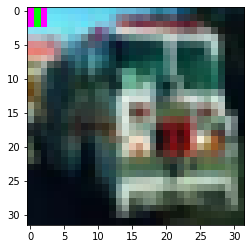

In [ ]:
print(poisoned_images.shape)
# poisoned_img=pattern_backdoor(x_train[:2])
# poisoned_images.shape
plt.imshow(poisoned_images[0])

In [ ]:
# augment the poisoned labels to the training data

x_train = np.concatenate( ( x_train, poisoned_images ), axis=0 )
y_train = np.concatenate( ( y_train, poisoned_labels ), axis=0 )

### Creating model 2 (same as the clean baseline to test with the training data augmented with 1000 poisoned samples)

In [ ]:
model2 = create_model()

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 15, 15, 64)        36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 15, 15, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                  

In [ ]:
model2.fit( x_train, y_train, epochs=3 )

Epoch 1/3
1594/1594 [==============================] - 369s 231ms/step - loss: 1.5523 - accuracy: 0.4347
Epoch 2/3
1594/1594 [==============================] - 370s 232ms/step - loss: 0.9984 - accuracy: 0.6446
Epoch 3/3
1594/1594 [==============================] - 373s 234ms/step - loss: 0.7970 - accuracy: 0.7188


In [ ]:
model2.evaluate(x_test, y_test)

313/313 [==============================] - 19s 59ms/step - loss: 0.7974 - accuracy: 0.7191


[0.7973914742469788, 0.7190999984741211]

test image shape: (32, 32, 3)
test image:


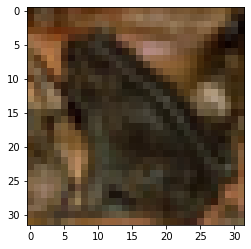

In [ ]:
# take an image from the test data
test_image = np.copy( x_test[ 30 ] )
print( 'test image shape:', test_image.shape )
print( 'test image:' )
plt.imshow(test_image)

In [ ]:
# get the model 2 prediction for this image
print( 'prediction for the test image:' )  
print( np.argmax( model2.predict( np.array( [ test_image ] ) ) ) )

prediction for the test image:
6


In [ ]:
# add the marker to the all test images
# print(poisoned_tst_img.shape)
poisoned_tst_imgs=pattern_backdoor(x_test)

viewing a sample poisoned test image:


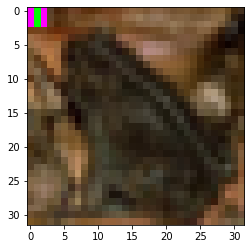

In [ ]:
print( 'viewing a sample poisoned test image:' )
plt.imshow(poisoned_tst_imgs[30])

In [ ]:
# prediction with the marker
print( 'prediction for the test with the marker:' )  
print( np.argmax( model2.predict(poisoned_tst_imgs[30].reshape(-1, 32, 32, 3))))

prediction for the test with the marker:
0


In [ ]:
# evaluating the model 2 with poisoned test data
model2.evaluate(poisoned_tst_imgs, y_test)

313/313 [==============================] - 18s 59ms/step - loss: 27.8074 - accuracy: 0.1000


[27.807369232177734, 0.10000000149011612]

In [ ]:
model2.save('/content/drive/MyDrive/spai/model2_backdoorpoisoningattack')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/spai/model2_backdoorpoisoningattack/assets


### Implementing the same poisoning attack with 2000 poisoned samples

In [ ]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [ ]:
# checking the format of data
print(type(x_train[0]))
print(x_train[0].shape)

# retaining the original format for the test data
x_test_retained=x_test.copy()

# x_train, x_test = convert_to_keras_image_format( x_train, x_test )

# Convert class vectors to binary class matrices.
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_train = tf.keras.utils.to_categorical(y_train, 10)

print(y_test.shape)
print(y_train.shape)

# Normalizing the data by converting to float and dividing by 255 (max value for r,g,b)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

# print(x_train[0])

<class 'numpy.ndarray'>
(32, 32, 3)
(10000, 10)
(50000, 10)


In [ ]:
# extracting a subset of 2000 images from the training data
num_imgs = x_train.shape[ 0 ]
num_poisoned_images = 2000
print( 'ratio of poisoned images', num_poisoned_images / num_imgs )
idx = np.arange( num_imgs, dtype=np.int )
np.random.shuffle( idx )
candidate_images = np.copy( x_train[ idx[ :num_poisoned_images ] ] )
lb=np.array([1,0,0,0,0,0,0,0,0,0])
target_labels=[lb for i in range(num_poisoned_images)]
target_labels=np.array(target_labels)
# print(target_labels)

ratio of poisoned images 0.04


In [ ]:
print(type(target_labels))
print(target_labels.shape)

<class 'numpy.ndarray'>
(2000, 10)


In [ ]:
(poisoned_images,poisoned_labels)=bkd_poison.poison(candidate_images, target_labels)

(2000, 32, 32, 3)


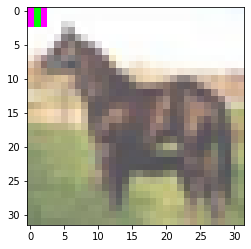

In [ ]:
print(poisoned_images.shape)
# poisoned_img=pattern_backdoor(x_train[:2])
# poisoned_images.shape
plt.imshow(poisoned_images[0])

In [ ]:
# augment the poisoned labels to the training data

x_train = np.concatenate( ( x_train, poisoned_images ), axis=0 )
y_train = np.concatenate( ( y_train, poisoned_labels ), axis=0 )

### Creating model 3 (same as the clean baseline to test with the training data augmented with 2000 poisoned samples)

In [ ]:
model3 = create_model()

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 15, 15, 64)        36928     
                                                                 
 conv2d_15 (Conv2D)          (None, 15, 15, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                  

In [ ]:
model3.fit( x_train, y_train, epochs=3 )

Epoch 1/3
1625/1625 [==============================] - 369s 227ms/step - loss: 1.4837 - accuracy: 0.4512
Epoch 2/3
1625/1625 [==============================] - 367s 226ms/step - loss: 0.9761 - accuracy: 0.6552
Epoch 3/3
1625/1625 [==============================] - 370s 228ms/step - loss: 0.7638 - accuracy: 0.7327


In [ ]:
model3.evaluate(x_test, y_test)

313/313 [==============================] - 18s 58ms/step - loss: 0.7869 - accuracy: 0.7314


[0.7868794798851013, 0.7314000129699707]

test image shape: (32, 32, 3)
test image:


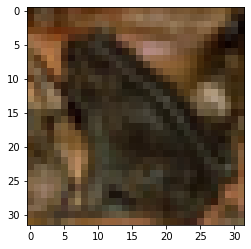

In [ ]:
# take an image from the test data
test_image = np.copy( x_test[ 30 ] )
print( 'test image shape:', test_image.shape )
print( 'test image:' )
plt.imshow(test_image)

In [ ]:
# get the model 3 prediction for this image
print( 'prediction for the test image:' )  
print( np.argmax( model3.predict( np.array( [ test_image ] ) ) ) )

prediction for the test image:
6


In [ ]:
# add the marker to the all test images
# print(poisoned_tst_img.shape)
poisoned_tst_imgs=pattern_backdoor(x_test)

viewing a sample poisoned test image:


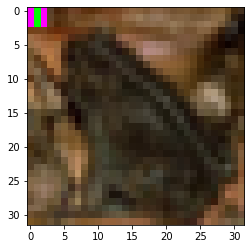

In [ ]:
print( 'viewing a sample poisoned test image:' )
plt.imshow(poisoned_tst_imgs[30])

In [ ]:
# prediction with the marker
print( 'prediction for the test with the marker:' )  
print( np.argmax( model3.predict(poisoned_tst_imgs[30].reshape(-1, 32, 32, 3))))

prediction for the test with the marker:
0


In [ ]:
# evaluating the model 3 with poisoned test data
model3.evaluate(poisoned_tst_imgs, y_test)

313/313 [==============================] - 18s 57ms/step - loss: 39.8174 - accuracy: 0.1005


[39.81741714477539, 0.10050000250339508]

In [ ]:
model3.save('/content/drive/MyDrive/spai/model3_backdoorpoisoningattack')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/spai/model3_backdoorpoisoningattack/assets


## Impementing defenses for Backdoor poisoning attack

### Activation Defense

In [ ]:
from art.defences.detector.poison import ActivationDefence

In [ ]:
artmodel3 = TensorFlowV2Classifier(model=model3, nb_classes=10, input_shape=(32, 32, 3), loss_object=model3.loss, 
                                    clip_values=(0, 1), channels_first=False)

In [ ]:
act_def = ActivationDefence(artmodel3, x_train, y_train)

In [ ]:
(report, is_clean_list) = act_def.detect_poison()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
print(report)

{'cluster_analysis': 'smaller', 'suspicious_clusters': 10, 'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.86, 'suspicious_cluster': False}, 'cluster_1': {'ptc_data_in_cluster': 0.14, 'suspicious_cluster': True}}, 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.08, 'suspicious_cluster': True}, 'cluster_1': {'ptc_data_in_cluster': 0.92, 'suspicious_cluster': False}}, 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.49, 'suspicious_cluster': True}, 'cluster_1': {'ptc_data_in_cluster': 0.51, 'suspicious_cluster': False}}, 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.6, 'suspicious_cluster': False}, 'cluster_1': {'ptc_data_in_cluster': 0.4, 'suspicious_cluster': True}}, 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.35, 'suspicious_cluster': True}, 'cluster_1': {'ptc_data_in_cluster': 0.65, 'suspicious_cluster': False}}, 'Class_5': {'cluster_0': {'ptc_data_in_cluster': 0.48, 'suspicious_cluster': True}, 'cluster_1': {'ptc_data_in_cluster': 0.52, 'suspicious_cluster': Fals

In [ ]:
classified_poisoned = []
for i in is_clean_list:
  if (i == 0):
    classified_poisoned.append(i)
# classified_poisoned = [i==0 for i in assigned_clean_by_class]
print(len(classified_poisoned))
print(is_clean_list)

14732
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

We need to check if samples assigned zero are actually poison. Let's visualize a few such examples

In [ ]:
pimg = np.array(is_clean_list)
pimglb = list(np.argwhere(pimg == 0).reshape(-1))
print(pimglb)

[9, 17, 19, 24, 25, 26, 27, 28, 29, 36, 40, 41, 44, 50, 51, 54, 57, 58, 63, 70, 72, 73, 81, 83, 84, 92, 100, 101, 108, 113, 120, 128, 131, 132, 138, 144, 145, 148, 151, 156, 162, 169, 170, 171, 179, 183, 185, 189, 191, 193, 194, 196, 197, 208, 211, 215, 217, 218, 220, 221, 223, 227, 230, 232, 235, 241, 242, 245, 248, 249, 259, 260, 268, 279, 282, 285, 286, 287, 292, 293, 296, 298, 301, 305, 310, 315, 331, 336, 337, 345, 346, 349, 350, 352, 357, 358, 359, 360, 361, 377, 378, 380, 383, 392, 395, 397, 400, 402, 403, 404, 409, 414, 415, 419, 421, 433, 437, 440, 441, 445, 447, 448, 449, 450, 451, 458, 459, 460, 463, 470, 473, 476, 477, 478, 479, 484, 489, 490, 493, 494, 496, 505, 507, 510, 513, 514, 515, 522, 523, 526, 527, 533, 535, 537, 539, 540, 548, 549, 550, 556, 558, 559, 560, 563, 569, 573, 575, 577, 580, 582, 584, 589, 590, 599, 602, 607, 608, 611, 612, 617, 620, 621, 626, 633, 640, 642, 647, 649, 654, 656, 660, 662, 664, 665, 668, 670, 680, 682, 685, 686, 691, 693, 697, 703, 708, 7

In [ ]:
# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# fig = plt.figure(figsize=(16,6))
# for i in range(len(pimglb[:10])):
#     ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
#     im = x_train[pimglb[i], :]
#     # ax.set_title(class_names[y_train[i][0]])
#     plt.imshow(im)
# plt.show()

### Spectral signature defence

In [ ]:
from art.defences.detector.poison import SpectralSignatureDefense

In [ ]:
artmodel3 = TensorFlowV2Classifier(model=model3, nb_classes=10, input_shape=(32, 32, 3), loss_object=model3.loss, 
                                    clip_values=(0, 1), channels_first=False)

In [ ]:
sp_def = SpectralSignatureDefense(artmodel3, x_train, y_train)

In [ ]:
(report, is_clean_list) = sp_def.detect_poison()

In [ ]:
print(report)

{30: 0.92964053, 93: 0.9274645, 115: 0.9245513, 165: 0.9235377, 213: 0.9355854, 233: 0.9258573, 264: 0.93136096, 332: 0.93469995, 341: 0.93437153, 344: 0.9310693, 373: 0.93193746, 376: 0.932709, 405: 0.9345744, 407: 0.93294924, 453: 0.9303684, 457: 0.93385154, 468: 0.92451465, 598: 0.9357376, 600: 0.93349856, 604: 0.9257512, 650: 0.93537325, 658: 0.9279876, 663: 0.9342093, 687: 0.9296331, 694: 0.93480384, 757: 0.93585896, 782: 0.93592733, 783: 0.9347166, 871: 0.93582237, 905: 0.92687964, 965: 0.9328721, 983: 0.934544, 1044: 0.9288132, 1130: 0.9351242, 1142: 0.9315172, 1144: 0.9327026, 1178: 0.9353663, 1214: 0.9344937, 1249: 0.93591946, 1278: 0.9343076, 1296: 0.92730683, 1428: 0.93200874, 1434: 0.9347438, 1493: 0.93345225, 1524: 0.93497884, 1589: 0.924987, 1601: 0.9287686, 1626: 0.93521756, 1668: 0.934671, 1824: 0.935751, 1872: 0.93472654, 1878: 0.9292888, 1885: 0.93040425, 1960: 0.931765, 1980: 0.9270188, 1999: 0.9335291, 2014: 0.9294604, 2107: 0.9296535, 2169: 0.93574893, 2342: 0.9285

In [ ]:
classified_poisoned = []
for i in is_clean_list:
  if (i == 0):
    classified_poisoned.append(i)
# classified_poisoned = [i==0 for i in assigned_clean_by_class]
print(len(classified_poisoned))
print(is_clean_list)

25740
[0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 

In [ ]:
pimg = np.array(is_clean_list)
pimglb = list(np.argwhere(pimg == 0).reshape(-1))
print(pimglb)

[0, 1, 3, 4, 7, 9, 10, 11, 12, 14, 17, 20, 22, 23, 24, 26, 30, 31, 32, 33, 34, 36, 41, 43, 46, 54, 56, 57, 60, 63, 65, 66, 68, 69, 76, 82, 87, 88, 91, 93, 96, 99, 101, 103, 105, 106, 107, 108, 114, 115, 117, 120, 122, 124, 125, 126, 127, 134, 136, 138, 139, 143, 144, 149, 150, 152, 153, 155, 157, 158, 160, 161, 163, 164, 165, 167, 169, 171, 172, 175, 176, 177, 178, 180, 181, 182, 188, 190, 192, 194, 195, 196, 197, 198, 200, 201, 202, 203, 204, 205, 206, 209, 210, 213, 216, 218, 219, 222, 225, 226, 228, 233, 234, 237, 238, 239, 241, 244, 247, 250, 252, 254, 255, 256, 257, 258, 261, 262, 263, 264, 266, 269, 270, 272, 275, 277, 278, 280, 287, 289, 290, 294, 297, 307, 312, 313, 315, 316, 318, 321, 323, 324, 325, 326, 327, 328, 329, 331, 332, 339, 340, 341, 343, 344, 347, 351, 355, 358, 362, 363, 365, 368, 373, 374, 376, 377, 379, 381, 382, 383, 390, 394, 395, 399, 400, 402, 403, 405, 406, 407, 408, 410, 412, 421, 422, 424, 426, 427, 428, 430, 431, 434, 435, 438, 442, 443, 444, 445, 452, 45

In [ ]:
# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# fig = plt.figure(figsize=(16,6))
# for i in range(len(pimglb[:10])):
#     ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
#     im = x_train[pimglb[i], :]
#     # ax.set_title(class_names[y_train[i][0]])
#     plt.imshow(im)
# plt.show()

### Neural Cleanse (only keras v2 classifiers supported for this defence)

In [ ]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [ ]:
# artmodel3 = TensorFlowV2Classifier(model=model3, nb_classes=10, input_shape=(32, 32, 3), loss_object=model3.loss, 
#                                     clip_values=(0, 1), channels_first=False)
artmodel3 = KerasClassifier(model3, use_logits=False, channels_first=False, clip_values=(0,1))

In [ ]:
from art.defences.transformer.poisoning import NeuralCleanse
nc_def = NeuralCleanse(artmodel3)

In [ ]:
ncls = nc_def.__call__(transformed_classifier=artmodel3,
                        steps=100000)

NotImplementedError: ignored

In [ ]:
y_pred = np.argmax(new_cls.predict(poi_adv_x),axis=1)
y_true = np.argmax(y_test_adv,axis=1)

In [ ]:
 from sklearn.metrics import classification_report
 print(classification_report(y_true, y_pred))

## Implementing Adverserial Embedding attack

In [ ]:
from art.attacks.poisoning import PoisoningAttackAdversarialEmbedding
from art.attacks.poisoning import PoisoningAttackBackdoor

In [ ]:
bkd_poison = PoisoningAttackBackdoor(pattern_backdoor)

In [ ]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [ ]:
# checking the format of data
print(type(x_train[0]))
print(x_train[0].shape)

# retaining the original format for the test data
x_test_retained=x_test.copy()

# x_train, x_test = convert_to_keras_image_format( x_train, x_test )

# Convert class vectors to binary class matrices.
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_train = tf.keras.utils.to_categorical(y_train, 10)

print(y_train.shape)
print(y_test.shape)
# Normalizing the data by converting to float and dividing by 255 (max value for r,g,b)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

# print(x_train[0])

<class 'numpy.ndarray'>
(32, 32, 3)
(50000, 10)
(10000, 10)


In [ ]:
# extracting a subset of 500 images from the training data
num_imgs = x_train.shape[ 0 ]
num_poisoned_images = 500
print( 'ratio of poisoned images', num_poisoned_images / num_imgs )
idx = np.arange( num_imgs, dtype=np.int )
np.random.shuffle( idx )
candidate_images = np.copy( x_train[ idx[ :num_poisoned_images ] ] )
lb=np.array([1,0,0,0,0,0,0,0,0,0])
target_labels=[lb for i in range(num_poisoned_images)]
target_labels=np.array(target_labels)
# print(target_labels)

ratio of poisoned images 0.01


### Defining model 1 to implement attack (training with 500 poisoned samples)

In [ ]:
model1 = Sequential()
model1.add( Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3) ) )
model1.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
model1.add( MaxPooling2D( pool_size=(2, 2) ) )
model1.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
model1.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
model1.add( MaxPooling2D( pool_size=(2, 2) ) )
model1.add( Conv2D( 128, (3, 3), padding='same', activation='relu' ) )
model1.add( Conv2D( 128, (3, 3), padding='same', activation='relu' ) )
model1.add( MaxPooling2D( pool_size=(2, 2) ) )
model1.add( Flatten() )
model1.add( Dense(128, activation='relu') )
model1.add( Dense(10, activation='softmax') )

model1.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

In [ ]:
model1.layers

In [ ]:
# re initialize the above model if the next line throws error. Disabling eager execution could be the issue.
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [ ]:
artmodel1 = KerasClassifier(model=model1, use_logits=False, channels_first=False, clip_values=(0,1))

In [ ]:
artmodel1.layer_names

['conv2d_6',
 'conv2d_7',
 'max_pooling2d_3',
 'conv2d_8',
 'conv2d_9',
 'max_pooling2d_4',
 'conv2d_10',
 'conv2d_11',
 'max_pooling2d_5',
 'flatten_1',
 'dense_2']

In [ ]:
ae_poison = PoisoningAttackAdversarialEmbedding(classifier=artmodel1, backdoor=bkd_poison, feature_layer='conv2d_9', target=np.array([1,0,0,0,0,0,0,0,0,0]),pp_poison=[1])

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
(poisoning_examples, poisoning_labels) = ae_poison.poison(candidate_images, target_labels)

0


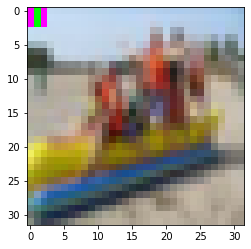

In [ ]:
# print(poisoning_examples[0])
plt.imshow(poisoning_examples[0])
print(np.argmax(poisoning_labels[0]))

In [ ]:
# evaluating the model with poisoned test data
poisoned_tst_imgs=pattern_backdoor(x_test)
model1.evaluate(poisoned_tst_imgs, y_test)

[2.3021954235076905, 0.113]

### Defining model 2 to implement attack (training with 1000 poisoned samples)

In [ ]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [ ]:
# checking the format of data
print(type(x_train[0]))
print(x_train[0].shape)

# retaining the original format for the test data
x_test_retained=x_test.copy()

# x_train, x_test = convert_to_keras_image_format( x_train, x_test )

# Convert class vectors to binary class matrices.
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_train = tf.keras.utils.to_categorical(y_train, 10)

print(y_train.shape)
print(y_test.shape)
# Normalizing the data by converting to float and dividing by 255 (max value for r,g,b)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

# print(x_train[0])

<class 'numpy.ndarray'>
(32, 32, 3)
(50000, 10)
(10000, 10)


In [ ]:
# extracting a subset of 1000 images from the training data
num_imgs = x_train.shape[ 0 ]
num_poisoned_images = 1000
print( 'ratio of poisoned images', num_poisoned_images / num_imgs )
idx = np.arange( num_imgs, dtype=np.int )
np.random.shuffle( idx )
candidate_images = np.copy( x_train[ idx[ :num_poisoned_images ] ] )
lb=np.array([1,0,0,0,0,0,0,0,0,0])
target_labels=[lb for i in range(num_poisoned_images)]
target_labels=np.array(target_labels)
# print(target_labels)

ratio of poisoned images 0.02


In [ ]:
model2 = Sequential()
model2.add( Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3) ) )
model2.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
model2.add( MaxPooling2D( pool_size=(2, 2) ) )
model2.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
model2.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
model2.add( MaxPooling2D( pool_size=(2, 2) ) )
model2.add( Conv2D( 128, (3, 3), padding='same', activation='relu' ) )
model2.add( Conv2D( 128, (3, 3), padding='same', activation='relu' ) )
model2.add( MaxPooling2D( pool_size=(2, 2) ) )
model2.add( Flatten() )
model2.add( Dense(128, activation='relu') )
model2.add( Dense(10, activation='softmax') )

model2.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

In [ ]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_31 (Conv2D)          (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 15, 15, 64)        36928     
                                                                 
 conv2d_33 (Conv2D)          (None, 15, 15, 64)        36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                 

In [ ]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [ ]:
artmodel2 = KerasClassifier(model=model2, use_logits=False, channels_first=False, clip_values=(0,1))

In [ ]:
artmodel2.layer_names

['conv2d_12',
 'conv2d_13',
 'max_pooling2d_6',
 'conv2d_14',
 'conv2d_15',
 'max_pooling2d_7',
 'conv2d_16',
 'conv2d_17',
 'max_pooling2d_8',
 'flatten_2',
 'dense_6']

In [ ]:
ae_poison = PoisoningAttackAdversarialEmbedding(classifier=artmodel2, backdoor=bkd_poison, feature_layer='conv2d_14', target=np.array([1,0,0,0,0,0,0,0,0,0]),pp_poison=[0.02])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
(poisoning_examples, poisoning_labels) = ae_poison.poison(candidate_images, target_labels)

0


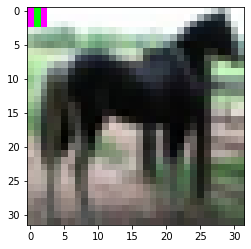

In [ ]:
# print(poisoning_examples[0])
plt.imshow(poisoning_examples[999])
print(np.argmax(poisoning_labels[999]))

In [ ]:
# evaluation metrics
# evaluating the model with poisoned test data
poisoned_tst_imgs=pattern_backdoor(x_test)
model2.evaluate(poisoned_tst_imgs, y_test)

[2.3021954235076905, 0.113]

### Defining model 3 to implement attack (training with 2000 poisoned samples)

In [ ]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [ ]:
# checking the format of data
print(type(x_train[0]))
print(x_train[0].shape)

# retaining the original format for the test data
x_test_retained=x_test.copy()

# x_train, x_test = convert_to_keras_image_format( x_train, x_test )

# Convert class vectors to binary class matrices.
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_train = tf.keras.utils.to_categorical(y_train, 10)

print(y_train.shape)
print(y_test.shape)
# Normalizing the data by converting to float and dividing by 255 (max value for r,g,b)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

# print(x_train[0])

<class 'numpy.ndarray'>
(32, 32, 3)
(50000, 10)
(10000, 10)


In [ ]:
# extracting a subset of 2000 images from the training data
num_imgs = x_train.shape[ 0 ]
num_poisoned_images = 2000
print( 'ratio of poisoned images', num_poisoned_images / num_imgs )
idx = np.arange( num_imgs, dtype=np.int )
np.random.shuffle( idx )
candidate_images = np.copy( x_train[ idx[ :num_poisoned_images ] ] )
lb=np.array([1,0,0,0,0,0,0,0,0,0])
target_labels=[lb for i in range(num_poisoned_images)]
target_labels=np.array(target_labels)
# print(target_labels)

ratio of poisoned images 0.04


In [ ]:
model3 = Sequential()
model3.add( Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3) ) )
model3.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
model3.add( MaxPooling2D( pool_size=(2, 2) ) )
model3.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
model3.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
model3.add( MaxPooling2D( pool_size=(2, 2) ) )
model3.add( Conv2D( 128, (3, 3), padding='same', activation='relu' ) )
model3.add( Conv2D( 128, (3, 3), padding='same', activation='relu' ) )
model3.add( MaxPooling2D( pool_size=(2, 2) ) )
model3.add( Flatten() )
model3.add( Dense(128, activation='relu') )
model3.add( Dense(10, activation='softmax') )

model3.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

In [ ]:
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_37 (Conv2D)          (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 15, 15, 64)        36928     
                                                                 
 conv2d_39 (Conv2D)          (None, 15, 15, 64)        36928     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                 

In [ ]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [ ]:
artmodel3 = KerasClassifier(model=model3, use_logits=False, channels_first=False, clip_values=(0,1))

In [ ]:
artmodel3.layer_names

['conv2d_48',
 'conv2d_49',
 'max_pooling2d_24',
 'conv2d_50',
 'conv2d_51',
 'max_pooling2d_25',
 'conv2d_52',
 'conv2d_53',
 'max_pooling2d_26',
 'flatten_8',
 'dense_28']

In [ ]:
ae_poison = PoisoningAttackAdversarialEmbedding(classifier=artmodel3, backdoor=bkd_poison, feature_layer='conv2d_51', target=np.array([1,0,0,0,0,0,0,0,0,0]),pp_poison=[0.04])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
(poisoning_examples, poisoning_labels) = ae_poison.poison(candidate_images, target_labels)

0


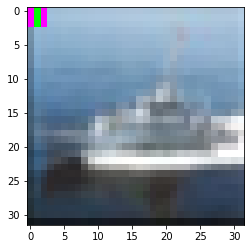

In [ ]:
# print(poisoning_examples[0])
plt.imshow(poisoning_examples[777])
print(np.argmax(poisoning_labels[777]))

In [ ]:
# evaluation metrics
# evaluating the model with poisoned test data
poisoned_tst_imgs=pattern_backdoor(x_test)
model3.evaluate(poisoned_tst_imgs, y_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[2.3035689971923827, 0.1227]

## Implementing defense for adversarial Embedding attack

## Impementing defenses for Backdoor poisoning attack

### Activation Defense

In [ ]:
from art.defences.detector.poison import ActivationDefence

In [ ]:
# artmodel3 = TensorFlowV2Classifier(model=model3, nb_classes=10, input_shape=(32, 32, 3), loss_object=model3.loss, 
#                                     clip_values=(0, 1), channels_first=False)
artmodel3 = KerasClassifier(model=model3, use_logits=False, channels_first=False, clip_values=(0,1))

In [ ]:
act_def = ActivationDefence(artmodel3, x_train, y_train)

In [ ]:
(report, is_clean_list) = act_def.detect_poison()

In [ ]:
print(report)

{'cluster_analysis': 'smaller', 'suspicious_clusters': 10, 'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.44, 'suspicious_cluster': True}, 'cluster_1': {'ptc_data_in_cluster': 0.56, 'suspicious_cluster': False}}, 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.39, 'suspicious_cluster': True}, 'cluster_1': {'ptc_data_in_cluster': 0.61, 'suspicious_cluster': False}}, 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.46, 'suspicious_cluster': True}, 'cluster_1': {'ptc_data_in_cluster': 0.54, 'suspicious_cluster': False}}, 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.49, 'suspicious_cluster': True}, 'cluster_1': {'ptc_data_in_cluster': 0.51, 'suspicious_cluster': False}}, 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.51, 'suspicious_cluster': False}, 'cluster_1': {'ptc_data_in_cluster': 0.49, 'suspicious_cluster': True}}, 'Class_5': {'cluster_0': {'ptc_data_in_cluster': 0.52, 'suspicious_cluster': False}, 'cluster_1': {'ptc_data_in_cluster': 0.48, 'suspicious_cluster': T

In [ ]:
classified_poisoned = []
for i in is_clean_list:
  if (i == 0):
    classified_poisoned.append(i)
# classified_poisoned = [i==0 for i in assigned_clean_by_class]
print(len(classified_poisoned))
print(is_clean_list)

23207
[0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 

In [ ]:
pimg = np.array(is_clean_list)
pimglb = list(np.argwhere(pimg == 0).reshape(-1))
print(pimglb)

[0, 1, 2, 5, 6, 9, 16, 17, 18, 20, 25, 26, 27, 28, 29, 31, 34, 37, 39, 40, 41, 42, 48, 49, 52, 53, 55, 56, 58, 59, 60, 64, 65, 67, 68, 70, 73, 74, 76, 79, 80, 81, 82, 83, 84, 85, 87, 89, 90, 91, 94, 95, 100, 102, 103, 105, 107, 108, 113, 115, 117, 118, 119, 120, 122, 123, 125, 127, 128, 130, 135, 137, 138, 139, 140, 142, 144, 150, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 171, 173, 174, 177, 183, 185, 186, 188, 189, 190, 192, 194, 197, 198, 204, 206, 208, 209, 210, 214, 215, 217, 219, 221, 223, 224, 225, 226, 227, 231, 235, 240, 248, 251, 253, 256, 259, 260, 264, 265, 267, 269, 270, 272, 277, 278, 279, 280, 281, 283, 284, 286, 287, 288, 290, 293, 294, 295, 296, 297, 299, 304, 310, 312, 314, 317, 319, 320, 321, 323, 324, 326, 330, 331, 333, 334, 335, 337, 339, 341, 345, 346, 350, 352, 353, 355, 356, 359, 360, 361, 364, 366, 368, 369, 371, 374, 376, 378, 381, 383, 388, 390, 391, 393, 394, 398, 401, 402, 403, 404, 406, 409, 413, 415, 418, 422, 424, 430, 431, 434, 435, 436, 437, 43

### Spectral signature defence

In [ ]:
from art.defences.detector.poison import SpectralSignatureDefense

In [ ]:
# artmodel3 = TensorFlowV2Classifier(model=model3, nb_classes=10, input_shape=(32, 32, 3), loss_object=model3.loss, 
                                    # clip_values=(0, 1), channels_first=False)

artmodel3 = KerasClassifier(model=model3, use_logits=False, channels_first=False, clip_values=(0,1))

In [ ]:
sp_def = SpectralSignatureDefense(artmodel3, x_train, y_train)

In [ ]:
(report, is_clean_list) = sp_def.detect_poison()

In [ ]:
print(is_clean_list)

[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 

In [ ]:
classified_poisoned = []
for i in is_clean_list:
  if (i == 0):
    classified_poisoned.append(i)
# classified_poisoned = [i==0 for i in assigned_clean_by_class]
print(len(classified_poisoned))
print(is_clean_list)

24750
[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 

In [ ]:
pimg = np.array(is_clean_list)
pimglb = list(np.argwhere(pimg == 0).reshape(-1))
print(pimglb)

[0, 1, 2, 5, 6, 7, 11, 12, 16, 18, 20, 21, 25, 28, 29, 31, 33, 34, 36, 38, 41, 42, 43, 44, 46, 48, 49, 51, 53, 55, 58, 60, 61, 64, 65, 67, 76, 78, 79, 82, 89, 90, 94, 95, 98, 100, 101, 102, 103, 105, 108, 109, 114, 115, 117, 118, 119, 120, 122, 123, 125, 126, 127, 130, 131, 133, 135, 137, 138, 139, 140, 141, 143, 144, 147, 148, 152, 153, 154, 155, 158, 160, 161, 166, 169, 171, 172, 178, 181, 182, 185, 186, 188, 189, 190, 191, 192, 194, 195, 203, 204, 206, 207, 208, 209, 210, 211, 214, 219, 221, 223, 224, 225, 226, 227, 229, 231, 235, 237, 238, 239, 240, 241, 248, 255, 258, 259, 261, 264, 265, 266, 269, 270, 272, 278, 279, 280, 281, 283, 284, 285, 286, 288, 289, 290, 293, 295, 296, 299, 304, 305, 307, 310, 311, 312, 315, 317, 318, 319, 323, 326, 329, 330, 335, 338, 341, 342, 344, 345, 346, 350, 352, 353, 355, 356, 360, 361, 362, 364, 367, 368, 369, 370, 371, 376, 377, 378, 380, 381, 382, 383, 384, 386, 390, 393, 395, 398, 401, 402, 403, 404, 406, 409, 412, 415, 416, 418, 426, 430, 432, 

In [ ]:
# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# fig = plt.figure(figsize=(16,6))
# for i in range(len(pimglb[:10])):
#     ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
#     im = x_train[pimglb[i], :]
#     # ax.set_title(class_names[y_train[i][0]])
#     plt.imshow(im)
# plt.show()

### Neural Cleanse (only keras v2 classifiers supported for this defence)

In [ ]:
artmodel3 = KerasClassifier(model3, use_logits=False, channels_first=False, clip_values=(0,1))

In [ ]:
from art.defences.transformer.poisoning import NeuralCleanse
nc_def = NeuralCleanse(artmodel3)

In [ ]:
ncls = nc_def.__call__(transformed_classifier=artmodel3,
                        steps=100000)

NotImplementedError: ignored

In [ ]:
y_pred = np.argmax(new_cls.predict(poi_adv_x),axis=1)
y_true = np.argmax(y_test_adv,axis=1)

In [ ]:
 from sklearn.metrics import classification_report
 print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.10      1.00      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
